In [5]:
#Needs to be run only once

import Pkg
Pkg.add("PyPlot")
Pkg.add("FastGaussQuadrature")
Pkg.add("Polynomials")

 Resolving package versions...


┌ Warning: julia version requirement for package Jacobi not satisfied
└ @ Pkg.Operations /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.0/Pkg/src/Operations.jl:183


  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...


┌ Warning: julia version requirement for package Jacobi not satisfied
└ @ Pkg.Operations /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.0/Pkg/src/Operations.jl:183


  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...


┌ Warning: julia version requirement for package Jacobi not satisfied
└ @ Pkg.Operations /builddir/build/BUILD/julia/build/usr/share/julia/stdlib/v1.0/Pkg/src/Operations.jl:183


  Updating `~/.julia/environments/v1.0/Project.toml`
  [f27b6e38] + Polynomials v0.5.1
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


# Eady Problem

First define some functions and constants associated with the Eady background state.

In [1]:
function u_linear(value)
    return value 
end

function dz(value::Float64) # du/dz for u_bar
    return 1
end 

function dq(value::Float64)
    return 0
end

function S_constant(value::Float64)
    return 1.
end

first_coefficient = 0.5 # barotropic coefficient for u_bar
u_zero = 0 # u_bar at z=0
beta = 0.0
;

Now define some functions associated with the exact solution to the Eady problem.

In [2]:
function cEady(kxValue::Float64)
    inner = (kxValue/2-coth(kxValue/2))*(kxValue/2-tanh(kxValue/2))
    c_value = 1/2 + 1/kxValue*((Complex(inner))^(1/2))
    return c_value
end

function AB(kxValue::Float64)
    c_value = cEady(kxValue)
    matrix = [ 1 kxValue*c_value; (c_value-1)*kxValue*sinh(kxValue)+1*cosh(kxValue) (c_value-1)*kxValue*cosh(kxValue)+1*sinh(kxValue)]
    solutions = nullspace(matrix)
    return solutions
end

function waveFunction(kxValue::Float64, zHeight)
    ABVal = AB(kxValue)
    waveReturn = ABVal[1]*cosh(kxValue*zHeight)+ABVal[2]*sinh(kxValue*zHeight)
    return waveReturn
end
;

Now generate a figure comparing the exact solution of the Eady problem to the new energy-conserving Galerkin approximation and the Chebyshev collocation method. The first block generates smaller versions of the four figures made in blocks 2-5.

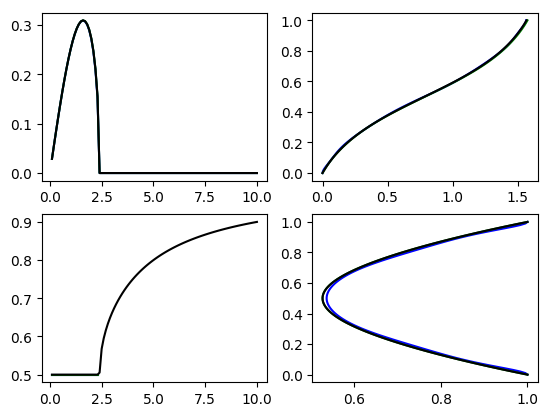

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6bce1ed2b0>

In [6]:
using PyPlot
using Polynomials
include("ChebyshevLinearStability.jl")
include("GalerkinLinearStability.jl")

matrixSize = 10
nodePoints = matrixSize + 2
# In the Eady problem, using nodePoints=matrixSize+2 is sufficient to
# guarantee machine-precision accuracy in the quadrature

kxStart = 0.1
kxFinish = 10.
steps = 100

ky = 0
kxs= collect(LinRange(kxStart, kxFinish, steps)) 


###
### Galerkin Method
###
eigenValuesAndVectors_eady_four = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates_G, vectors_G, waveSpeeds_G = getStabilityValues(eigenValuesAndVectors_eady_four, kxs)

#Test Galerkin Line
#createFourStabilityPlots(matrixSize, S_constant, growthRates_G, vectors_G, w_speeds_G, kxs, ky)

###Compiling Relevant Infomation from the Galerkin Method
B = B_ij(matrixSize)
L = L_ij(matrixSize, S_constant)
M = M_ij(matrixSize)

maxIndex_G = argmax(growthRates_G)
maxKx_G = kxs[maxIndex_G]
highVector_G = vectors_G[maxIndex_G]
vectorSize = length(highVector_G)
highVector_bottom = highVector_G[vectorSize] 
psi_coeffs = highVector_G[1]*psi(matrixSize, maxKx_G, ky, M, L, 1.)-highVector_bottom*psi(matrixSize,maxKx_G,ky, M,L,0.)
psi_coeffs = psi_coeffs - ( (maxKx_G^2 + ky^2)*M + L ) \ B*highVector_G[2:end-1]

heights_G = collect(LinRange(0,1,100))
psi_angles_G = zeros(length(heights_G))
psi_amps_G = zeros(length(heights_G))

for i=1:length(heights_G)
    psi_val_G = galerkin_p_psi_print(matrixSize, psi_coeffs, heights_G[i])
    psi_angles_G[i] = angle(psi_val_G)
    psi_amps_G[i] = abs(psi_val_G)
end


###
### Chebyshev Collocation
###
growthRates_C, eigenvectors_C, waveSpeeds_C = growthRateEigenValues_Cheb(matrixSize, beta, ky, kxs, S_constant, dq, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), 0.)

#Test Chebyshev Line
#createFourStabilityPlots_Cheb(matrixSize, S_constant, growthRates_C, eigenvectors_C, waveSpeeds_C, kxs, ky)

###Compiling Relevant Info from Chebyshev Method
D_C = chebyshevDM(matrixSize)
L_C = L_Cheb(matrixSize, S_constant)

maxIndex_C = argmax(growthRates_C)
maxKx_C = kxs[maxIndex_C]

highVector_C = eigenvectors_C[maxIndex_C]
vectorSize = length(highVector_C)
psi_C = highVector_C

chebZ = chebyshevZ(matrixSize)
heights_C = collect(LinRange(0,1,100))
psi_angles_C = polyval(polyfit(chebZ,angle.(psi_C)),heights_C)
psi_amps_C = polyval(polyfit(chebZ,abs.(psi_C)),heights_C)
#psi_angles_C = zeros(length(heights_C))
#psi_amps_C = zeros(length(heights_C))
#for i=1:length(heights_C)
#    psi_angles_C[i] = angle(psi_C[i])
#    psi_amps_C[i] = abs(psi_C[i])
#end

###
### Exact Solution
###

#Exact Growth Rates and wave speeds
growthRates_E = zeros(length(kxs))
waveSpeeds_E = zeros(length(kxs))
for i =1:length(kxs)
    c_value = cEady(kxs[i])
    growthRates_E[i] = kxs[i]*imag(c_value)
    waveSpeeds_E[i] = real(c_value)
end

#Exact Angles and Amplitude
heights_E = collect(LinRange(0,1,100))
psi_angles_E = zeros(length(heights_E))
psi_amps_E = zeros(length(heights_E))
for i=1:length(heights_E)
    psiValueExact = waveFunction(1.61, heights_E[i])
    psi_angles_E[i]= angle(psiValueExact)
    psi_amps_E[i] = abs(psiValueExact)
end

fig, axes = subplots(2,2)
    ax = axes[1,1]
    ax[:plot](kxs, growthRates_G, color="b")
    ax[:plot](kxs, growthRates_C, color="g")
    ax[:plot](kxs, growthRates_E, color="k")
    ax = axes[2,1]
    ax[:plot](kxs, waveSpeeds_G, color="b")
    ax[:plot](kxs, waveSpeeds_C, color="g")
    ax[:plot](kxs, waveSpeeds_E, color="k")
    
    ax = axes[1,2]
    ax[:plot](psi_angles_G .- psi_angles_G[1], heights_G, color="b")
    ax[:plot](psi_angles_C .- psi_angles_C[1], heights_C, color="g")
    ax[:plot](psi_angles_E .- psi_angles_E[1], heights_E, color="k")

    ax = axes[2,2]
    ax[:plot](psi_amps_G/maximum(psi_amps_G), heights_G, color="b")
    ax[:plot](psi_amps_C/maximum(psi_amps_C), heights_C, color="g")
    ax[:plot](psi_amps_E/maximum(psi_amps_E), heights_E, color="k")

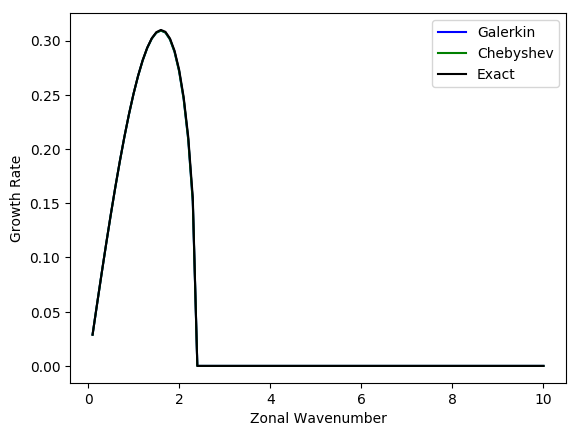

In [8]:
plot(kxs, growthRates_G, label="Galerkin", color="b")
plot(kxs, growthRates_G, label="Chebyshev", color="g")
plot(kxs, growthRates_E, label="Exact",color="k")
legend(loc="upper right")
xlabel("Zonal Wavenumber")
ylabel("Growth Rate")
savefig("EadyGrowthRates.eps", format="eps", dpi=1000)

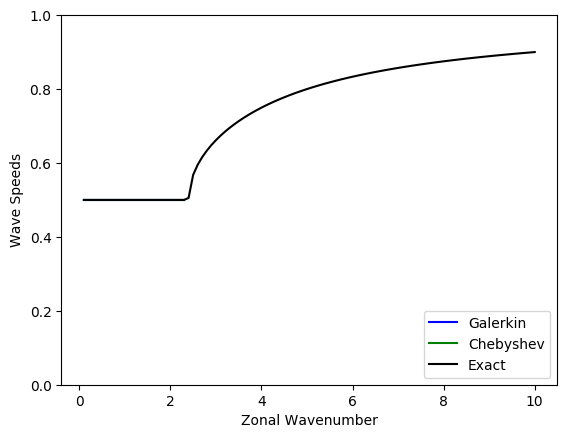

In [12]:
plot(kxs, waveSpeeds_G, label="Galerkin", color="b")
plot(kxs, waveSpeeds_C, label="Chebyshev", color="g")
plot(kxs, waveSpeeds_E, label="Exact", color="k")
ylim(0,1)
legend(loc="lower right")
xlabel("Zonal Wavenumber")
ylabel("Wave Speeds")
savefig("EadyWaveSpeeds.eps", format="eps", dpi=1000) 

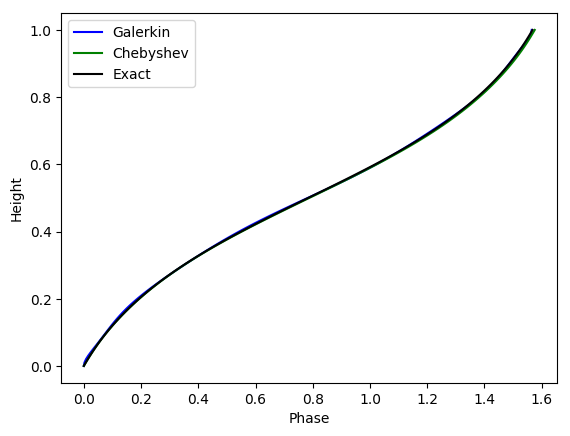

In [13]:
plot(psi_angles_G .- psi_angles_G[1], heights_G, label="Galerkin", color="b")
plot(psi_angles_C .- psi_angles_C[1], heights_C, label="Chebyshev", color="g")
plot(psi_angles_E .- psi_angles_E[1], heights_E, label="Exact", color="k")
legend(loc="upper left")
xlabel("Phase")
ylabel("Height")
savefig("EadyPhase.eps", format="eps", dpi=1000)

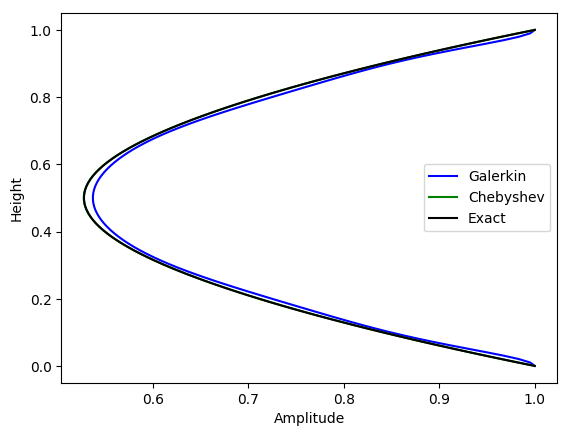

In [14]:
plot(psi_amps_G/maximum(psi_amps_G), heights_G, label="Galerkin", color="b")
plot(psi_amps_C/maximum(psi_amps_C), heights_C, label="Chebyshev", color="g")
plot(psi_amps_E/maximum(psi_amps_E), heights_E, label="Exact", color="k")
legend(loc="center right")
xlabel("Amplitude")
ylabel("Height")
savefig("EadyAmplitude.eps", format="eps", dpi=1000)

Next compare the convergence of the growth rate at kx=1.61, ky=0 (approximately the fastest-growing mode) for the Galerkin, second-order energy-conserving finite-difference, and non-energy-conserving Chebyshev collocation methods.

In [3]:
include("FDLinearStability.jl")
include("ChebyshevLinearStability.jl")
include("GalerkinLinearStability.jl")

max_kxs = 1.61
ky = 0.0
sN = 2 .^(3:7)

growthRates_G = zeros(length(sN))
growthRates_F = zeros(length(sN))
growthRates_C = zeros(length(sN))

for ii=1:length(sN)
    matrixSize = sN[ii]
    nodePoints = matrixSize + 2
    eigenValuesAndVectors_G = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, max_kxs, S_constant, dq, dz, 1.0, 1.0, first_coefficient)
    growthRates, eVecs, waveSpeeds = getStabilityValues(eigenValuesAndVectors_G, max_kxs)
    growthRates_G[ii] = maximum(growthRates)

    growthRates, eVecs, waveSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, max_kxs, S_constant, u_linear)
    growthRates_F[ii] = maximum(growthRates)

    growthRates, eVecs, waveSpeeds = growthRateEigenValues_Cheb(matrixSize, beta, ky, max_kxs, S_constant, dq, 1.0, 1.0, u_zero)
    growthRates_C[ii] = maximum(growthRates)
    
    println("Done with ", sN[ii])
end

Done with 8
Done with 16
Done with 32
Done with 64
Done with 128


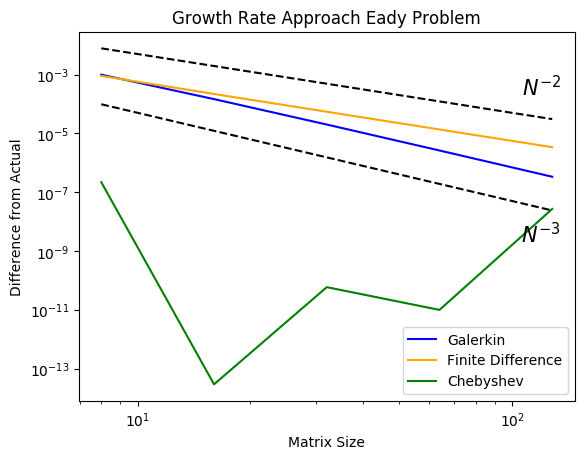

In [4]:
#Needs the above cell run first
using PyPlot
bestValue_eady = 1.61*imag(cEady(1.61))

diffs_G = abs.(growthRates_G.-bestValue_eady)
diffs_F = abs.(growthRates_F.-bestValue_eady)
diffs_C = abs.(growthRates_C.-bestValue_eady)
plot(sN,diffs_G, label="Galerkin", color="b")
plot(sN,diffs_F, label="Finite Difference", color="orange")
plot(sN,diffs_C, label="Chebyshev",color="g")
plot(sN, .5*float(sN).^-2, color="k", linestyle="dashed")
plot(sN, .05*float(sN).^-3, color="k", linestyle="dashed")
title("Growth Rate Approach Eady Problem")
xlabel("Matrix Size")
ylabel("Difference from Actual")
yscale("log")
xscale("log")
legend(loc="lower right")
annotate(L"$N^{-2}$",
	xy=[1;0.78],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
annotate(L"$N^{-3}$",
	xy=[1;0.38],
	xycoords="axes fraction",
	xytext=[-10,10],
	textcoords="offset points",
	fontsize=15.0,
	ha="right",
	va="bottom")
savefig("EadyApproach.eps", format="eps", dpi=1000)